# Environment Set Up

In [ ]:
from google.colab import drive
import os
import numpy as np
import random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

!pip install git+https://github.com/tensorflow/examples.git # install the tensorflow_examples package
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-0t97bepq
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-0t97bepq
  Resolved https://github.com/tensorflow/examples.git to commit 6a3a323f3885f16085ad8335392f7ec836c677f4
  Preparing metadata (setup.py) ... done


#Pull in Data

Starting With:
* 26 Black Positive
* 14 White Positive
* 14 Black None
* 8 White None
* 8 Black Other
* 15 White Other


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define base directory
base_dir = "/content/drive/My Drive/images"

# Define folder names
folders = ["blacknone", "blackother", "blackpositive", "whitenone", "whiteother", "whitepositive"]

# Create variables for each folder
blacknone = glob(os.path.join(base_dir, "blacknone", "*"))
blackother = glob(os.path.join(base_dir, "blackother", "*"))
blackpositive = glob(os.path.join(base_dir, "blackpositive", "*"))
whitenone = glob(os.path.join(base_dir, "whitenone", "*"))
whiteother = glob(os.path.join(base_dir, "whiteother", "*"))
whitepositive = glob(os.path.join(base_dir, "whitepositive", "*"))

# Print number of images in each
print("blacknone:", len(blacknone))
print("blackother:", len(blackother))
print("blackpositive:", len(blackpositive))
print("whitenone:", len(whitenone))
print("whiteother:", len(whiteother))
print("whitepositive:", len(whitepositive))

Mounted at /content/drive
blacknone: 14
blackother: 8
blackpositive: 26
whitenone: 11
whiteother: 15
whitepositive: 14


set up paths and loader

In [ ]:
IMG_SIZE = 256

def load_and_preprocess_image(path):
    img = Image.open(path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)
    return (arr / 127.5) - 1.0  # normalize to [-1, 1]

def make_dataset(path_list):
    ds = [load_and_preprocess_image(p) for p in path_list]
    return tf.data.Dataset.from_tensor_slices(ds).shuffle(100).batch(1)

black_ds = make_dataset(blackpositive)   # real X = blackpositive
white_ds = make_dataset(whitepositive)   # real Y = whitepositive

# Baseline Classifcation Model

In [ ]:
# Set parameters
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerators for loading data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80/20 train/val split
)

# Load training data
train_data = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data
val_data = datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Show class indices
print("Class Indices:", train_data.class_indices)




Found 73 images belonging to 6 classes.
Found 15 images belonging to 6 classes.
Class Indices: {'blacknone': 0, 'blackother': 1, 'blackpositive': 2, 'whitenone': 3, 'whiteother': 4, 'whitepositive': 5}


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 7

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.2121 - loss: 2.0479 - val_accuracy: 0.4667 - val_loss: 1.7612
Epoch 2/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - accuracy: 0.3054 - loss: 1.7885 - val_accuracy: 0.3333 - val_loss: 1.5173
Epoch 3/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step - accuracy: 0.3230 - loss: 1.5237 - val_accuracy: 0.4000 - val_loss: 1.4967
Epoch 4/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4652 - loss: 1.4197 - val_accuracy: 0.4000 - val_loss: 1.5064
Epoch 5/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4446 - loss: 1.3698 - val_accuracy: 0.4000 - val_loss: 1.3827
Epoch 6/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - accuracy: 0.4012 - loss: 1.2903 - val_accuracy: 0.4667 - val_loss: 1.3335
Epoch 7/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 883ms/step - accuracy: 0.5618 - loss: 1.1153 - val_accuracy: 0.4667 - val_loss: 1.3929


For baseline model:
* Accuracy: 0.56
* Loss: 1.12
* Validation Accuracy: 0.47
* Validation Loss: 1.39

# Generate white pos using Cycle GAN

build graph

In [ ]:
# build networks, losses, optimizers
OUTPUT_CHANNELS = 3
lambda_cycle = 10


gen_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # black→white
gen_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')  # white→black
disc_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
disc_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
opt_g = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
opt_f = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
opt_dx = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
opt_dy = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

training function

In [ ]:
def gan_loss(pred, target):
    return loss_obj(tf.ones_like(pred) if target=='real' else tf.zeros_like(pred), pred)

def cycle_loss(real, cycled):
    return tf.reduce_mean(tf.abs(real - cycled)) * lambda_cycle

def identity_loss(real, same):
    return tf.reduce_mean(tf.abs(real - same)) * (lambda_cycle * 0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # forward and backward
        fake_y = gen_g(real_x, training=True)
        fake_x = gen_f(real_y, training=True)
        cycled_x = gen_f(fake_y, training=True)
        cycled_y = gen_g(fake_x, training=True)
        same_x = gen_f(real_x, training=True)
        same_y = gen_g(real_y, training=True)

        # discriminator outputs
        d_real_x = disc_x(real_x, training=True)
        d_real_y = disc_y(real_y, training=True)
        d_fake_x = disc_x(fake_x, training=True)
        d_fake_y = disc_y(fake_y, training=True)

        # losses
        g_g_loss = gan_loss(d_fake_y, 'real') + cycle_loss(real_x, cycled_x) + identity_loss(real_y, same_y)
        g_f_loss = gan_loss(d_fake_x, 'real') + cycle_loss(real_y, cycled_y) + identity_loss(real_x, same_x)
        d_x_loss = 0.5 * (gan_loss(d_real_x, 'real') + gan_loss(d_fake_x, 'fake'))
        d_y_loss = 0.5 * (gan_loss(d_real_y, 'real') + gan_loss(d_fake_y, 'fake'))

    # apply gradients
    grads_g = tape.gradient(g_g_loss, gen_g.trainable_variables)
    grads_f = tape.gradient(g_f_loss, gen_f.trainable_variables)
    grads_dx = tape.gradient(d_x_loss, disc_x.trainable_variables)
    grads_dy = tape.gradient(d_y_loss, disc_y.trainable_variables)

    opt_g.apply_gradients(zip(grads_g, gen_g.trainable_variables))
    opt_f.apply_gradients(zip(grads_f, gen_f.trainable_variables))
    opt_dx.apply_gradients(zip(grads_dx, disc_x.trainable_variables))
    opt_dy.apply_gradients(zip(grads_dy, disc_y.trainable_variables))

training loop

In [ ]:
EPOCHS = 100
for epoch in range(1, EPOCHS+1):
    for real_black, real_white in tf.data.Dataset.zip((black_ds, white_ds)):
        train_step(real_black, real_white)

    if epoch % 10 == 0:
        print(f"Finished epoch {epoch}/{EPOCHS}")

Finished epoch 10/100
Finished epoch 20/100
Finished epoch 30/100
Finished epoch 40/100
Finished epoch 50/100
Finished epoch 60/100
Finished epoch 70/100
Finished epoch 80/100
Finished epoch 90/100
Finished epoch 100/100


generate and save synthetic whitepositive


In [ ]:
def generate_synthetic_images(num_images, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    it = iter(black_ds)
    for i in range(num_images):
        try:
            inp = next(it)
            fake = gen_g(inp, training=False)
            img = ((fake[0].numpy() + 1.0) * 127.5).clip(0,255).astype(np.uint8)
            Image.fromarray(img).save(os.path.join(output_folder, f"syn_{i+1:03d}.jpg"))
        except StopIteration:
            break

syn_folder = os.path.join(base_dir, "synwhitepositive")
generate_synthetic_images(len(blackpositive), syn_folder)
print(f"Synthetic whitepositive images saved to {syn_folder}")


Synthetic whitepositive images saved to /content/drive/My Drive/images/synwhitepositive


# Classifcation Model With Synthetic Images

In [ ]:
# Generate different sized sets
num_images_list = [4, 8, 12, 16, 20, 24]
syn_folders = []

for num in num_images_list:
    folder_name = f"synwhitepositive_{num}"
    syn_folder = generate_synthetic_images(num, os.path.join(base_dir, folder_name))
    syn_folders.append(syn_folder)
    print(f"Generated {num} synthetic images in {folder_name}")

Generated 4 synthetic images in synwhitepositive_4
Generated 8 synthetic images in synwhitepositive_8
Generated 12 synthetic images in synwhitepositive_12
Generated 16 synthetic images in synwhitepositive_16
Generated 20 synthetic images in synwhitepositive_20
Generated 24 synthetic images in synwhitepositive_24


In [ ]:
def load_images_from_folder(folder, label):
    paths = glob(os.path.join(folder, "*"))
    data = []
    for path in paths:
        img = Image.open(path).convert("RGB").resize((128, 128))
        img = np.array(img).astype(np.float32) / 255.0  # normalize
        data.append((img, label))
    return data

# Class labels
label_map = {
    "none": 0,
    "other": 1,
    "positive": 2,
}

# Paths to all folders
all_data = []

for skintone in ["black", "white"]:
    for subtype in ["none", "other", "positive"]:
        folder = os.path.join(base_dir, f"{skintone}{subtype}")
        label = label_map[subtype]
        all_data.extend(load_images_from_folder(folder, label))

# Add synthetic whitepositive
all_data.extend(load_images_from_folder(syn_folder, label_map["positive"]))

In [ ]:
# Shuffle and split
random.shuffle(all_data)
X, y = zip(*all_data)
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

Epoch 1/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3941 - loss: 1.6010 - val_accuracy: 0.3478 - val_loss: 1.3034
Epoch 2/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4087 - loss: 1.0372 - val_accuracy: 0.6087 - val_loss: 0.9982
Epoch 3/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6626 - loss: 0.8798 - val_accuracy: 0.5652 - val_loss: 0.7971
Epoch 4/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7008 - loss: 0.7366 - val_accuracy: 0.6522 - val_loss: 0.7071
Epoch 5/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7746 - loss: 0.5941 - val_accuracy: 0.6957 - val_loss: 0.7287
Epoch 6/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8559 - loss: 0.5121 - val_accuracy: 0.7391 - val_loss: 0.6353
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Accuracy with 4 synthetic images: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Accuracy with 8 synthetic images: 0.7778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Accuracy with 12 syn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Accuracy with 16 synthetic images: 0.6667


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Accuracy with 20 synthetic images: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Accuracy with 24 synthetic images: 0.7778


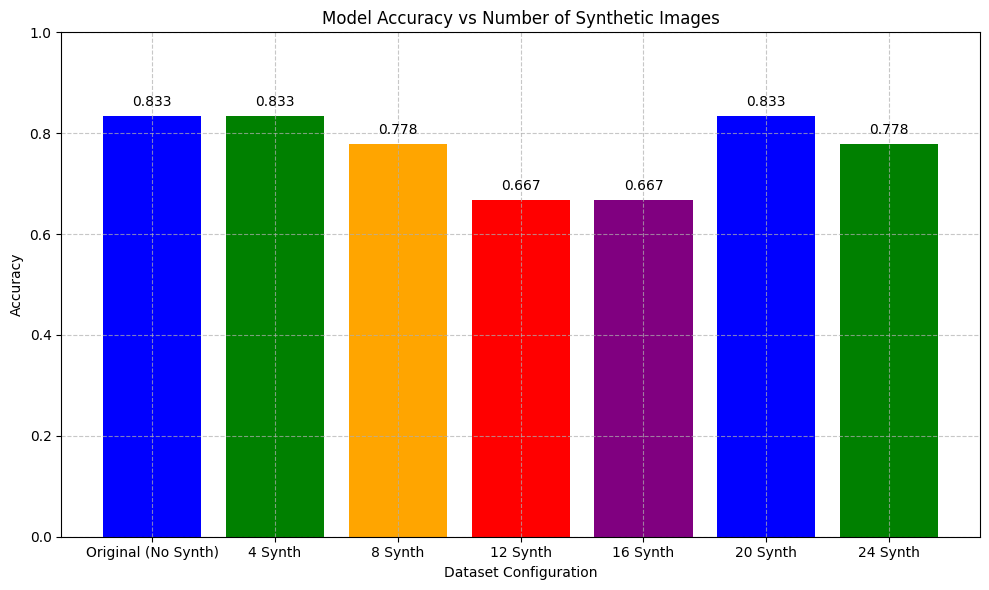

In [ ]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, epochs=6, validation_data=test_ds)

def evaluate_with_synthetic(syn_folder):
    # Load all data
    all_data = []

    # Original categories
    for skintone in ["black", "white"]:
        for subtype in ["none", "other", "positive"]:
            folder = os.path.join(base_dir, f"{skintone}{subtype}")
            label = label_map[subtype]
            all_data.extend(load_images_from_folder(folder, label))


     # Add synthetic images only if syn_folder is provided
    if syn_folder:  # Check if syn_folder is not None
        all_data.extend(load_images_from_folder(os.path.join(base_dir, syn_folder), label_map["positive"]))

    # Prepare dataset
    random.shuffle(all_data)
    X, y = zip(*all_data)
    X = np.array(X)
    y = np.array(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Create new model (same architecture)
    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train and evaluate
    history = model.fit(train_ds, epochs=6, validation_data=test_ds, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y_test, y_pred_classes)

# Evaluate all configurations
accuracies = []
config_names = ["Original (No Synth)"] + [f"{num} Synth" for num in num_images_list]

# Baseline (no synthetic)
baseline_acc = evaluate_with_synthetic(None)
accuracies.append(baseline_acc)

# With each synthetic set
for i, folder in enumerate(syn_folders):
    acc = evaluate_with_synthetic(folder)
    accuracies.append(acc)
    print(f"Accuracy with {num_images_list[i]} synthetic images: {acc:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(config_names, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Accuracy vs Number of Synthetic Images')
plt.xlabel('Dataset Configuration')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Test Accuracy: 75%